# Initial EDA

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import text

from utils import setup_import

setup_import()

from fraud_detection.data.database import get_db_engine

plt.style.use("ggplot")
sns.set_palette("Set2")

%matplotlib inline

%load_ext autoreload
%autoreload 2

ROOT: /workspace/fraud-ml-pipeline
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
print("Connecting to DB...")
engine = get_db_engine()

query = text("""
             SELECT * FROM transactions ORDER BY trans_date LIMIT 1000000
             """)

df = pd.read_sql_query(sql=query, con=engine)

df["trans_data_trans_time"] = pd.to_datetime(df["trans_date"] + " " + df["trans_time"])

df["dod"] = pd.to_datetime(df["dob"])

df["is_fraud"] = df["is_fraud"].astype(int)
df = df.drop(["trans_date", "trans_time"], axis=1)

print(f"{df.shape=}")
df.info()
df.head()

Connecting to DB...
df.shape=(1000000, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   ssn                    1000000 non-null  object        
 1   cc_num                 1000000 non-null  int64         
 2   first                  1000000 non-null  object        
 3   last                   1000000 non-null  object        
 4   gender                 1000000 non-null  object        
 5   street                 1000000 non-null  object        
 6   city                   1000000 non-null  object        
 7   state                  1000000 non-null  object        
 8   zip                    1000000 non-null  int64         
 9   lat                    1000000 non-null  float64       
 10  long                   1000000 non-null  float64       
 11  city_pop               1000000 non-null  int64 

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,trans_data_trans_time,dod
0,745-09-1426,6585487099861626,Brittany,Matthews,F,91485 Baker Shoal,Tony,WI,54563,45.4741,...,9970c2d002015be6384bc3eef3f8af6d,1704073640,gas_transport,92.91,0,"fraud_Reilly, Heaney and Cole",45.342331,-91.919985,2024-01-01 10:47:20,1998-07-29
1,015-42-8701,4033542168940,Carol,Colon,F,7898 Hamilton Spur Apt. 575,Champlain,VA,22438,38.0214,...,a2e1333feb3142acc6279ce505621028,1704074136,gas_transport,108.12,0,fraud_Ledner-Pfannerstill,37.567759,-77.694131,2024-01-01 10:55:36,1986-07-06
2,400-40-3758,4722820055775,Vanessa,Fernandez,F,728 Brittany Motorway Suite 884,Harpersville,AL,35078,33.3234,...,478e409841efd1a2f1765cd9ce8a4e74,1704065682,gas_transport,97.70,0,"fraud_Lind, Huel and McClure",34.185202,-86.506550,2024-01-01 08:34:42,1994-10-03
3,400-40-3758,4722820055775,Vanessa,Fernandez,F,728 Brittany Motorway Suite 884,Harpersville,AL,35078,33.3234,...,c414c97a47fe849d2d8497274cff33a7,1704045780,gas_transport,78.99,0,fraud_Schmitt Inc,32.507215,-87.418474,2024-01-01 03:03:00,1994-10-03
4,162-48-5106,3599102290147672,Lisa,Perry,F,156 Justin Springs,West Valley,NY,14171,42.4315,...,d6e8a023d90501254999840907eb46fd,1704054617,gas_transport,60.55,0,fraud_Berge LLC,41.446588,-79.023898,2024-01-01 05:30:17,1981-07-27


## 1. Descritive Statistics

### Place vs. Amount

In [ ]:
display(df[['amt', 'lat', 'long', 'merch_lat', 'merch_long']].describe())

,amt,lat,long,merch_lat,merch_long
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,84.762808,37.477572,-92.067697,37.478504,-92.068748
std,120.546637,5.186742,16.413034,5.218728,16.422893
min,1.000000,19.589300,-164.436100,18.606801,-165.409986
25%,33.550000,33.905600,-98.668800,33.874407,-99.010929
50%,61.590000,38.250700,-87.554800,38.181432,-87.300017
75%,88.970000,41.076800,-80.056000,41.187016,-79.779823
max,17635.230000,64.910900,-67.472200,65.907181,-66.490662


### Distribution of Fraud

In [16]:
df["is_fraud"].value_counts(normalize=True) * 100

is_fraud
0    98.6192
1     1.3808
Name: proportion, dtype: float64

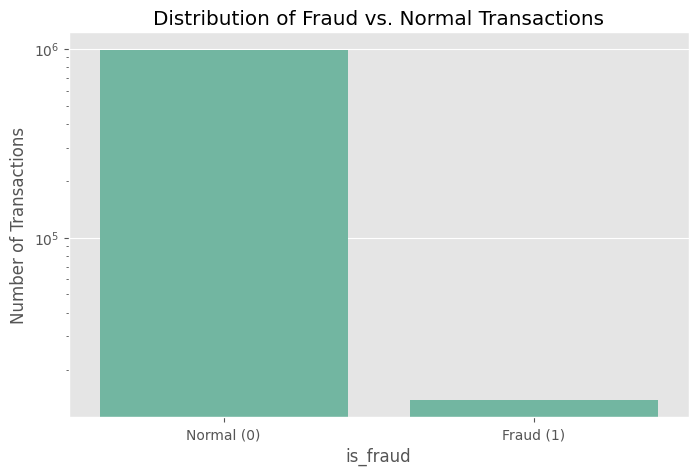

In [28]:
plt.figure(figsize=(8, 5))
sns.countplot(x='is_fraud', data=df)
plt.title('Distribution of Fraud vs. Normal Transactions')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'])
plt.show()

### Fraud vs. Amount

In [30]:
df.groupby('is_fraud')['amt'].describe()


,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,986192.0,78.504537,98.71123,1.00,33.4300,61.27,87.6600,17635.23
1,13808.0,531.739676,392.29390,1.47,244.3425,399.13,909.5425,1373.64


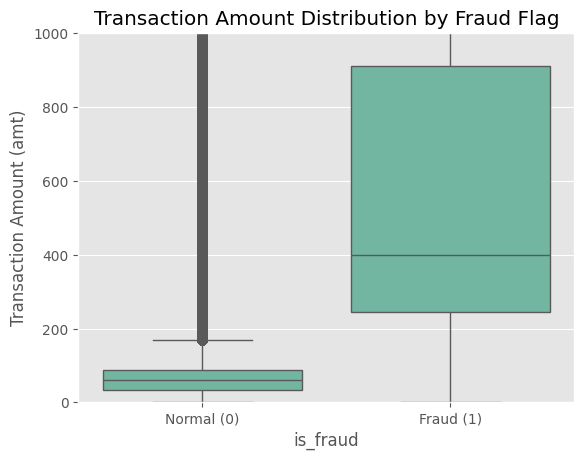

In [42]:
# 取引金額は外れ値が多い可能性があるため、y軸の上限を絞って見やすくする
sns.boxplot(x='is_fraud', y='amt', data=df)
plt.title('Transaction Amount Distribution by Fraud Flag')
plt.ylim(0, 1000) # y軸の表示範囲を0から400に限定。適宜調整してください。
plt.ylabel('Transaction Amount (amt)')
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'])
plt.show()

<Figure size 1000x600 with 0 Axes>

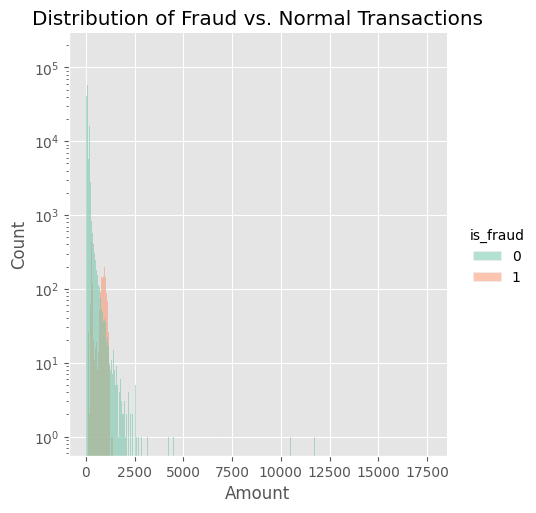

In [40]:
plt.figure(figsize=(10, 6))
sns.displot(data=df, x="amt", hue="is_fraud")
plt.title('Distribution of Fraud vs. Normal Transactions')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.yscale('log')
plt.show()